<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/ShuffleNet_for_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 5/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 5/X_test.npy')
X_val = np.load('/content/drive/MyDrive/data for 5/X_val.npy')
Y_train = np.load('/content/drive/MyDrive/data for 5/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 5/Y_test.npy')
Y_val = np.load('/content/drive/MyDrive/data for 5/Y_val.npy')
label = np.load('/content/drive/MyDrive/data for 5/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((143120, 32, 32),
 (42967, 32, 32),
 (35780, 32, 32),
 (143120, 5),
 (42967, 5),
 (35780, 5))

In [5]:
X_train[0]

array([[0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       [0.        , 0.        , 0.        , ..., 0.01568628, 0.01568628,
        0.01568628],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.15686275, 0.15686275,
        0.15686275]], dtype=float32)

In [6]:
X_val[0]

array([[0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       [0.        , 0.        , 0.        , ..., 0.03921569, 0.03921569,
        0.03921569],
       ...,
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.00392157, 0.00392157, 0.00392157, ..., 0.24313726, 0.24313726,
        0.24313726]], dtype=float32)

In [7]:
Y_train[0]

array([1., 0., 0., 0., 0.])

### Model and Train

In [8]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0],32,32,1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

def channel_shuffle(x, groups):
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    group_channels = channels // groups

    x = tf.reshape(x, [-1, height, width, groups, group_channels])
    x = tf.transpose(x, [0, 1, 2, 4, 3])
    x = tf.reshape(x, [-1, height, width, channels])
    return x

def grouped_convolution(x, out_channels, groups):
    in_channels = x.shape[-1]
    group_list = []

    for i in range(groups):
        group_list.append(layers.Conv2D(out_channels // groups, kernel_size=1, strides=1, padding='same',
                                        use_bias=False)(x[:, :, :, i * in_channels // groups:(i + 1) * in_channels // groups]))
    return layers.Concatenate()(group_list)

def shuffle_unit(inputs, in_channels, out_channels, strides, groups):
    x = grouped_convolution(inputs, in_channels, groups)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = grouped_convolution(x, out_channels if strides == 1 else out_channels - in_channels, groups)
    x = layers.BatchNormalization()(x)

    if strides == 2:
        shortcut = layers.AveragePooling2D(pool_size=3, strides=2, padding='same')(inputs)
        x = layers.Concatenate()([x, shortcut])
    elif strides == 1:
        x = layers.Add()([inputs, x])

    x = layers.ReLU()(x)
    x = channel_shuffle(x, groups)
    return x

def ShuffleNet(input_shape=(224, 224, 3), num_classes=1000, scale_factor=1.0, groups=3):
    in_channels = 24
    out_channels = {1: [144, 288, 576], 2: [200, 400, 800], 3: [240, 480, 960], 4: [272, 544, 1088], 8: [384, 768, 1536]}[groups]
    out_channels = [int(c * scale_factor) for c in out_channels]

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(in_channels, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for out_channel in out_channels:
        repeat = 4 if out_channel != out_channels[0] else 3
        for i in range(repeat):
            strides = 2 if i == 0 else 1
            x = shuffle_unit(x, in_channels, out_channel, strides, groups)
            in_channels = out_channel

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
model = ShuffleNet(input_shape = (32,32,1), num_classes = 5)
from keras.optimizers import SGD
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 24)           216       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 24)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 24)           0         ['batch_normalization[0][0

In [13]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True, monitor="val_accuraccy")
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, validation_data=(X_val, Y_val),callbacks=[es])

Epoch 1/50
560/559 [==============================] - ETA: 0s - loss: 1.4582 - accuracy: 0.3999 - f1_m: 0.3039 - precision_m: 0.5809 - recall_m: 0.2075

559/559 [==============================] - 88s 109ms/step - loss: 1.4582 - accuracy: 0.3999 - f1_m: 0.3039 - precision_m: 0.5809 - recall_m: 0.2075 - val_loss: 1.6193 - val_accuracy: 0.3129 - val_f1_m: 0.0672 - val_precision_m: 0.8068 - val_recall_m: 0.0352
Epoch 2/50
560/559 [==============================] - ETA: 0s - loss: 1.1811 - accuracy: 0.4965 - f1_m: 0.4119 - precision_m: 0.7006 - recall_m: 0.2927

559/559 [==============================] - 58s 104ms/step - loss: 1.1811 - accuracy: 0.4965 - f1_m: 0.4119 - precision_m: 0.7006 - recall_m: 0.2927 - val_loss: 1.2051 - val_accuracy: 0.4876 - val_f1_m: 0.4105 - val_precision_m: 0.6828 - val_recall_m: 0.2940
Epoch 3/50
560/559 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.5336 - f1_m: 0.4599 - precision_m: 0.7273 - recall_m: 0.3373

559/559 [==============================] - 57s 102ms/step - loss: 1.0874 - accuracy: 0.5336 - f1_m: 0.4599 - precision_m: 0.7273 - recall_m: 0.3373 - val_loss: 1.1559 - val_accuracy: 0.5185 - val_f1_m: 0.4621 - val_precision_m: 0.6621 - val_recall_m: 0.3554
Epoch 4/50
560/559 [==============================] - ETA: 0s - loss: 1.0014 - accuracy: 0.5743 - f1_m: 0.5157 - precision_m: 0.7438 - recall_m: 0.3954

559/559 [==============================] - 57s 102ms/step - loss: 1.0014 - accuracy: 0.5743 - f1_m: 0.5157 - precision_m: 0.7438 - recall_m: 0.3954 - val_loss: 1.0742 - val_accuracy: 0.5466 - val_f1_m: 0.4987 - val_precision_m: 0.6862 - val_recall_m: 0.3921
Epoch 5/50
560/559 [==============================] - ETA: 0s - loss: 0.9662 - accuracy: 0.5922 - f1_m: 0.5412 - precision_m: 0.7465 - recall_m: 0.4253

559/559 [==============================] - 59s 106ms/step - loss: 0.9662 - accuracy: 0.5922 - f1_m: 0.5412 - precision_m: 0.7465 - recall_m: 0.4253 - val_loss: 1.1036 - val_accuracy: 0.5490 - val_f1_m: 0.5044 - val_precision_m: 0.6804 - val_recall_m: 0.4011
Epoch 6/50
560/559 [==============================] - ETA: 0s - loss: 0.9160 - accuracy: 0.6153 - f1_m: 0.5746 - precision_m: 0.7557 - recall_m: 0.4641

559/559 [==============================] - 58s 104ms/step - loss: 0.9160 - accuracy: 0.6153 - f1_m: 0.5746 - precision_m: 0.7557 - recall_m: 0.4641 - val_loss: 0.9290 - val_accuracy: 0.6175 - val_f1_m: 0.5896 - val_precision_m: 0.7229 - val_recall_m: 0.4982
Epoch 7/50
560/559 [==============================] - ETA: 0s - loss: 0.8815 - accuracy: 0.6343 - f1_m: 0.5984 - precision_m: 0.7612 - recall_m: 0.4934

559/559 [==============================] - 58s 104ms/step - loss: 0.8815 - accuracy: 0.6343 - f1_m: 0.5984 - precision_m: 0.7612 - recall_m: 0.4934 - val_loss: 0.9174 - val_accuracy: 0.6169 - val_f1_m: 0.5917 - val_precision_m: 0.7303 - val_recall_m: 0.4977
Epoch 8/50
560/559 [==============================] - ETA: 0s - loss: 0.8514 - accuracy: 0.6473 - f1_m: 0.6174 - precision_m: 0.7691 - recall_m: 0.5161

559/559 [==============================] - 59s 106ms/step - loss: 0.8514 - accuracy: 0.6473 - f1_m: 0.6174 - precision_m: 0.7691 - recall_m: 0.5161 - val_loss: 0.9503 - val_accuracy: 0.6066 - val_f1_m: 0.5840 - val_precision_m: 0.6978 - val_recall_m: 0.5024
Epoch 9/50
560/559 [==============================] - ETA: 0s - loss: 0.8239 - accuracy: 0.6607 - f1_m: 0.6335 - precision_m: 0.7752 - recall_m: 0.5360

559/559 [==============================] - 59s 105ms/step - loss: 0.8239 - accuracy: 0.6607 - f1_m: 0.6335 - precision_m: 0.7752 - recall_m: 0.5360 - val_loss: 0.8178 - val_accuracy: 0.6636 - val_f1_m: 0.6430 - val_precision_m: 0.7617 - val_recall_m: 0.5567
Epoch 10/50
560/559 [==============================] - ETA: 0s - loss: 0.8095 - accuracy: 0.6684 - f1_m: 0.6438 - precision_m: 0.7792 - recall_m: 0.5489

559/559 [==============================] - 58s 104ms/step - loss: 0.8095 - accuracy: 0.6684 - f1_m: 0.6438 - precision_m: 0.7792 - recall_m: 0.5489 - val_loss: 0.8793 - val_accuracy: 0.6441 - val_f1_m: 0.6248 - val_precision_m: 0.7327 - val_recall_m: 0.5449
Epoch 11/50
560/559 [==============================] - ETA: 0s - loss: 0.7799 - accuracy: 0.6812 - f1_m: 0.6598 - precision_m: 0.7849 - recall_m: 0.5695

559/559 [==============================] - 63s 112ms/step - loss: 0.7799 - accuracy: 0.6812 - f1_m: 0.6598 - precision_m: 0.7849 - recall_m: 0.5695 - val_loss: 0.8664 - val_accuracy: 0.6466 - val_f1_m: 0.6292 - val_precision_m: 0.7400 - val_recall_m: 0.5476
Epoch 12/50
560/559 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.6929 - f1_m: 0.6744 - precision_m: 0.7918 - recall_m: 0.5876

559/559 [==============================] - 58s 104ms/step - loss: 0.7522 - accuracy: 0.6929 - f1_m: 0.6744 - precision_m: 0.7918 - recall_m: 0.5876 - val_loss: 0.9082 - val_accuracy: 0.6397 - val_f1_m: 0.6265 - val_precision_m: 0.7186 - val_recall_m: 0.5555
Epoch 13/50
560/559 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.7003 - f1_m: 0.6828 - precision_m: 0.7954 - recall_m: 0.5985

559/559 [==============================] - 58s 103ms/step - loss: 0.7353 - accuracy: 0.7003 - f1_m: 0.6828 - precision_m: 0.7954 - recall_m: 0.5985 - val_loss: 0.8073 - val_accuracy: 0.6754 - val_f1_m: 0.6656 - val_precision_m: 0.7608 - val_recall_m: 0.5919
Epoch 14/50
560/559 [==============================] - ETA: 0s - loss: 0.7174 - accuracy: 0.7073 - f1_m: 0.6914 - precision_m: 0.7979 - recall_m: 0.6105

559/559 [==============================] - 58s 104ms/step - loss: 0.7174 - accuracy: 0.7073 - f1_m: 0.6914 - precision_m: 0.7979 - recall_m: 0.6105 - val_loss: 0.8755 - val_accuracy: 0.6463 - val_f1_m: 0.6327 - val_precision_m: 0.7274 - val_recall_m: 0.5601
Epoch 15/50
560/559 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6950 - f1_m: 0.6767 - precision_m: 0.7932 - recall_m: 0.5912

559/559 [==============================] - 58s 103ms/step - loss: 0.7521 - accuracy: 0.6950 - f1_m: 0.6767 - precision_m: 0.7932 - recall_m: 0.5912 - val_loss: 0.7799 - val_accuracy: 0.6812 - val_f1_m: 0.6657 - val_precision_m: 0.7746 - val_recall_m: 0.5839
Epoch 16/50
560/559 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.7167 - f1_m: 0.7029 - precision_m: 0.8063 - recall_m: 0.6233

559/559 [==============================] - 57s 103ms/step - loss: 0.6980 - accuracy: 0.7167 - f1_m: 0.7029 - precision_m: 0.8063 - recall_m: 0.6233 - val_loss: 0.7605 - val_accuracy: 0.6928 - val_f1_m: 0.6805 - val_precision_m: 0.7797 - val_recall_m: 0.6040
Epoch 17/50
560/559 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.7046 - f1_m: 0.6879 - precision_m: 0.7963 - recall_m: 0.6064

559/559 [==============================] - 58s 104ms/step - loss: 0.7270 - accuracy: 0.7046 - f1_m: 0.6879 - precision_m: 0.7963 - recall_m: 0.6064 - val_loss: 0.6999 - val_accuracy: 0.7179 - val_f1_m: 0.7050 - val_precision_m: 0.8008 - val_recall_m: 0.6299
Epoch 18/50
560/559 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.7312 - f1_m: 0.7196 - precision_m: 0.8133 - recall_m: 0.6455

559/559 [==============================] - 58s 103ms/step - loss: 0.6683 - accuracy: 0.7312 - f1_m: 0.7196 - precision_m: 0.8133 - recall_m: 0.6455 - val_loss: 0.8211 - val_accuracy: 0.6726 - val_f1_m: 0.6628 - val_precision_m: 0.7519 - val_recall_m: 0.5928
Epoch 19/50
560/559 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.7426 - f1_m: 0.7331 - precision_m: 0.8204 - recall_m: 0.6629

559/559 [==============================] - 59s 106ms/step - loss: 0.6396 - accuracy: 0.7426 - f1_m: 0.7331 - precision_m: 0.8204 - recall_m: 0.6629 - val_loss: 0.8217 - val_accuracy: 0.6799 - val_f1_m: 0.6707 - val_precision_m: 0.7444 - val_recall_m: 0.6105
Epoch 20/50
560/559 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7471 - f1_m: 0.7375 - precision_m: 0.8227 - recall_m: 0.6687

559/559 [==============================] - 57s 103ms/step - loss: 0.6325 - accuracy: 0.7471 - f1_m: 0.7375 - precision_m: 0.8227 - recall_m: 0.6687 - val_loss: 0.6905 - val_accuracy: 0.7258 - val_f1_m: 0.7205 - val_precision_m: 0.7948 - val_recall_m: 0.6593
Epoch 21/50
560/559 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.7416 - f1_m: 0.7314 - precision_m: 0.8186 - recall_m: 0.6617

559/559 [==============================] - 59s 105ms/step - loss: 0.6459 - accuracy: 0.7416 - f1_m: 0.7314 - precision_m: 0.8186 - recall_m: 0.6617 - val_loss: 0.7660 - val_accuracy: 0.6920 - val_f1_m: 0.6817 - val_precision_m: 0.7691 - val_recall_m: 0.6124
Epoch 22/50
560/559 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7580 - f1_m: 0.7499 - precision_m: 0.8277 - recall_m: 0.6857

559/559 [==============================] - 58s 103ms/step - loss: 0.6055 - accuracy: 0.7580 - f1_m: 0.7499 - precision_m: 0.8277 - recall_m: 0.6857 - val_loss: 0.7177 - val_accuracy: 0.7224 - val_f1_m: 0.7165 - val_precision_m: 0.7879 - val_recall_m: 0.6572
Epoch 23/50
560/559 [==============================] - ETA: 0s - loss: 0.5849 - accuracy: 0.7663 - f1_m: 0.7600 - precision_m: 0.8330 - recall_m: 0.6989

559/559 [==============================] - 59s 105ms/step - loss: 0.5849 - accuracy: 0.7663 - f1_m: 0.7600 - precision_m: 0.8330 - recall_m: 0.6989 - val_loss: 0.6905 - val_accuracy: 0.7324 - val_f1_m: 0.7286 - val_precision_m: 0.7949 - val_recall_m: 0.6727
Epoch 24/50
560/559 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.7590 - f1_m: 0.7516 - precision_m: 0.8282 - recall_m: 0.6885

559/559 [==============================] - 60s 107ms/step - loss: 0.6130 - accuracy: 0.7590 - f1_m: 0.7516 - precision_m: 0.8282 - recall_m: 0.6885 - val_loss: 0.6903 - val_accuracy: 0.7262 - val_f1_m: 0.7177 - val_precision_m: 0.7976 - val_recall_m: 0.6525
Epoch 25/50
560/559 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7712 - f1_m: 0.7644 - precision_m: 0.8352 - recall_m: 0.7049

559/559 [==============================] - 58s 104ms/step - loss: 0.5792 - accuracy: 0.7712 - f1_m: 0.7644 - precision_m: 0.8352 - recall_m: 0.7049 - val_loss: 0.6286 - val_accuracy: 0.7540 - val_f1_m: 0.7481 - val_precision_m: 0.8119 - val_recall_m: 0.6938
Epoch 26/50
560/559 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.7823 - f1_m: 0.7767 - precision_m: 0.8421 - recall_m: 0.7209

559/559 [==============================] - 59s 106ms/step - loss: 0.5515 - accuracy: 0.7823 - f1_m: 0.7767 - precision_m: 0.8421 - recall_m: 0.7209 - val_loss: 0.6441 - val_accuracy: 0.7475 - val_f1_m: 0.7431 - val_precision_m: 0.8077 - val_recall_m: 0.6884
Epoch 27/50
560/559 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7857 - f1_m: 0.7799 - precision_m: 0.8438 - recall_m: 0.7252

559/559 [==============================] - 59s 105ms/step - loss: 0.5454 - accuracy: 0.7857 - f1_m: 0.7799 - precision_m: 0.8438 - recall_m: 0.7252 - val_loss: 0.6386 - val_accuracy: 0.7492 - val_f1_m: 0.7455 - val_precision_m: 0.8087 - val_recall_m: 0.6917
Epoch 28/50
560/559 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.7856 - f1_m: 0.7810 - precision_m: 0.8426 - recall_m: 0.7281

559/559 [==============================] - 59s 106ms/step - loss: 0.5463 - accuracy: 0.7856 - f1_m: 0.7810 - precision_m: 0.8426 - recall_m: 0.7281 - val_loss: 0.9473 - val_accuracy: 0.6415 - val_f1_m: 0.6340 - val_precision_m: 0.7021 - val_recall_m: 0.5782
Epoch 29/50
560/559 [==============================] - ETA: 0s - loss: 0.5396 - accuracy: 0.7878 - f1_m: 0.7832 - precision_m: 0.8457 - recall_m: 0.7297

559/559 [==============================] - 60s 107ms/step - loss: 0.5396 - accuracy: 0.7878 - f1_m: 0.7832 - precision_m: 0.8457 - recall_m: 0.7297 - val_loss: 0.7025 - val_accuracy: 0.7326 - val_f1_m: 0.7289 - val_precision_m: 0.7835 - val_recall_m: 0.6815
Epoch 30/50
560/559 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.7986 - f1_m: 0.7953 - precision_m: 0.8527 - recall_m: 0.7454

559/559 [==============================] - 59s 105ms/step - loss: 0.5126 - accuracy: 0.7986 - f1_m: 0.7953 - precision_m: 0.8527 - recall_m: 0.7454 - val_loss: 0.6386 - val_accuracy: 0.7582 - val_f1_m: 0.7560 - val_precision_m: 0.8023 - val_recall_m: 0.7149
Epoch 31/50
560/559 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7806 - f1_m: 0.7757 - precision_m: 0.8401 - recall_m: 0.7210

559/559 [==============================] - 61s 108ms/step - loss: 0.5597 - accuracy: 0.7806 - f1_m: 0.7757 - precision_m: 0.8401 - recall_m: 0.7210 - val_loss: 0.7270 - val_accuracy: 0.7208 - val_f1_m: 0.7132 - val_precision_m: 0.7780 - val_recall_m: 0.6586
Epoch 32/50
560/559 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.7324 - f1_m: 0.7191 - precision_m: 0.8100 - recall_m: 0.6483

559/559 [==============================] - 59s 105ms/step - loss: 0.6732 - accuracy: 0.7324 - f1_m: 0.7191 - precision_m: 0.8100 - recall_m: 0.6483 - val_loss: 0.6417 - val_accuracy: 0.7501 - val_f1_m: 0.7439 - val_precision_m: 0.8110 - val_recall_m: 0.6872
Epoch 33/50
560/559 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.7944 - f1_m: 0.7903 - precision_m: 0.8500 - recall_m: 0.7386

559/559 [==============================] - 60s 108ms/step - loss: 0.5231 - accuracy: 0.7944 - f1_m: 0.7903 - precision_m: 0.8500 - recall_m: 0.7386 - val_loss: 0.6552 - val_accuracy: 0.7481 - val_f1_m: 0.7460 - val_precision_m: 0.8001 - val_recall_m: 0.6990
Epoch 34/50
560/559 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.8044 - f1_m: 0.8011 - precision_m: 0.8560 - recall_m: 0.7530

559/559 [==============================] - 60s 108ms/step - loss: 0.5013 - accuracy: 0.8044 - f1_m: 0.8011 - precision_m: 0.8560 - recall_m: 0.7530 - val_loss: 0.5697 - val_accuracy: 0.7845 - val_f1_m: 0.7832 - val_precision_m: 0.8321 - val_recall_m: 0.7399
Epoch 35/50
560/559 [==============================] - ETA: 0s - loss: 0.4934 - accuracy: 0.8084 - f1_m: 0.8046 - precision_m: 0.8579 - recall_m: 0.7578

559/559 [==============================] - 60s 107ms/step - loss: 0.4934 - accuracy: 0.8084 - f1_m: 0.8046 - precision_m: 0.8579 - recall_m: 0.7578 - val_loss: 0.5791 - val_accuracy: 0.7779 - val_f1_m: 0.7772 - val_precision_m: 0.8258 - val_recall_m: 0.7342
Epoch 36/50
560/559 [==============================] - ETA: 0s - loss: 0.4733 - accuracy: 0.8163 - f1_m: 0.8133 - precision_m: 0.8628 - recall_m: 0.7694

559/559 [==============================] - 59s 106ms/step - loss: 0.4733 - accuracy: 0.8163 - f1_m: 0.8133 - precision_m: 0.8628 - recall_m: 0.7694 - val_loss: 0.6118 - val_accuracy: 0.7667 - val_f1_m: 0.7643 - val_precision_m: 0.8154 - val_recall_m: 0.7195
Epoch 37/50
560/559 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8185 - f1_m: 0.8164 - precision_m: 0.8636 - recall_m: 0.7743

559/559 [==============================] - 61s 109ms/step - loss: 0.4680 - accuracy: 0.8185 - f1_m: 0.8164 - precision_m: 0.8636 - recall_m: 0.7743 - val_loss: 0.5958 - val_accuracy: 0.7745 - val_f1_m: 0.7751 - val_precision_m: 0.8170 - val_recall_m: 0.7375
Epoch 38/50
560/559 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.8251 - f1_m: 0.8232 - precision_m: 0.8682 - recall_m: 0.7827

559/559 [==============================] - 61s 108ms/step - loss: 0.4513 - accuracy: 0.8251 - f1_m: 0.8232 - precision_m: 0.8682 - recall_m: 0.7827 - val_loss: 0.6222 - val_accuracy: 0.7637 - val_f1_m: 0.7624 - val_precision_m: 0.8076 - val_recall_m: 0.7221
Epoch 39/50
560/559 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.8289 - f1_m: 0.8269 - precision_m: 0.8705 - recall_m: 0.7876

559/559 [==============================] - 60s 108ms/step - loss: 0.4430 - accuracy: 0.8289 - f1_m: 0.8269 - precision_m: 0.8705 - recall_m: 0.7876 - val_loss: 0.5460 - val_accuracy: 0.7957 - val_f1_m: 0.7959 - val_precision_m: 0.8376 - val_recall_m: 0.7582
Epoch 40/50
560/559 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.8305 - f1_m: 0.8278 - precision_m: 0.8705 - recall_m: 0.7892

559/559 [==============================] - 63s 112ms/step - loss: 0.4383 - accuracy: 0.8305 - f1_m: 0.8278 - precision_m: 0.8705 - recall_m: 0.7892 - val_loss: 0.6705 - val_accuracy: 0.7511 - val_f1_m: 0.7520 - val_precision_m: 0.7922 - val_recall_m: 0.7158
Epoch 41/50
560/559 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8328 - f1_m: 0.8316 - precision_m: 0.8719 - recall_m: 0.7950

559/559 [==============================] - 60s 107ms/step - loss: 0.4305 - accuracy: 0.8328 - f1_m: 0.8316 - precision_m: 0.8719 - recall_m: 0.7950 - val_loss: 0.5677 - val_accuracy: 0.7886 - val_f1_m: 0.7886 - val_precision_m: 0.8290 - val_recall_m: 0.7521
Epoch 42/50
560/559 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8376 - f1_m: 0.8360 - precision_m: 0.8762 - recall_m: 0.7995

559/559 [==============================] - 62s 110ms/step - loss: 0.4223 - accuracy: 0.8376 - f1_m: 0.8360 - precision_m: 0.8762 - recall_m: 0.7995 - val_loss: 0.5616 - val_accuracy: 0.7949 - val_f1_m: 0.7938 - val_precision_m: 0.8309 - val_recall_m: 0.7599
Epoch 43/50
560/559 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8347 - f1_m: 0.8333 - precision_m: 0.8727 - recall_m: 0.7973

559/559 [==============================] - 60s 108ms/step - loss: 0.4277 - accuracy: 0.8347 - f1_m: 0.8333 - precision_m: 0.8727 - recall_m: 0.7973 - val_loss: 0.5631 - val_accuracy: 0.7938 - val_f1_m: 0.7924 - val_precision_m: 0.8310 - val_recall_m: 0.7574
Epoch 44/50
560/559 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8403 - f1_m: 0.8387 - precision_m: 0.8768 - recall_m: 0.8040

559/559 [==============================] - 59s 106ms/step - loss: 0.4160 - accuracy: 0.8403 - f1_m: 0.8387 - precision_m: 0.8768 - recall_m: 0.8040 - val_loss: 0.6151 - val_accuracy: 0.7729 - val_f1_m: 0.7718 - val_precision_m: 0.8168 - val_recall_m: 0.7317
Epoch 45/50
560/559 [==============================] - ETA: 0s - loss: 0.4033 - accuracy: 0.8456 - f1_m: 0.8439 - precision_m: 0.8814 - recall_m: 0.8096

559/559 [==============================] - 59s 106ms/step - loss: 0.4033 - accuracy: 0.8456 - f1_m: 0.8439 - precision_m: 0.8814 - recall_m: 0.8096 - val_loss: 0.5485 - val_accuracy: 0.8007 - val_f1_m: 0.8014 - val_precision_m: 0.8366 - val_recall_m: 0.7692
Epoch 46/50
560/559 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8504 - f1_m: 0.8501 - precision_m: 0.8841 - recall_m: 0.8187

559/559 [==============================] - 60s 107ms/step - loss: 0.3911 - accuracy: 0.8504 - f1_m: 0.8501 - precision_m: 0.8841 - recall_m: 0.8187 - val_loss: 0.8330 - val_accuracy: 0.7114 - val_f1_m: 0.7108 - val_precision_m: 0.7463 - val_recall_m: 0.6787
Epoch 47/50
560/559 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8293 - f1_m: 0.8273 - precision_m: 0.8685 - recall_m: 0.7900

559/559 [==============================] - 60s 107ms/step - loss: 0.4437 - accuracy: 0.8293 - f1_m: 0.8273 - precision_m: 0.8685 - recall_m: 0.7900 - val_loss: 0.5779 - val_accuracy: 0.7893 - val_f1_m: 0.7891 - val_precision_m: 0.8240 - val_recall_m: 0.7571
Epoch 48/50
560/559 [==============================] - ETA: 0s - loss: 0.4113 - accuracy: 0.8427 - f1_m: 0.8409 - precision_m: 0.8784 - recall_m: 0.8067

559/559 [==============================] - 60s 108ms/step - loss: 0.4113 - accuracy: 0.8427 - f1_m: 0.8409 - precision_m: 0.8784 - recall_m: 0.8067 - val_loss: 0.5249 - val_accuracy: 0.8108 - val_f1_m: 0.8119 - val_precision_m: 0.8463 - val_recall_m: 0.7803
Epoch 49/50
560/559 [==============================] - ETA: 0s - loss: 0.3776 - accuracy: 0.8561 - f1_m: 0.8549 - precision_m: 0.8870 - recall_m: 0.8252

559/559 [==============================] - 58s 103ms/step - loss: 0.3776 - accuracy: 0.8561 - f1_m: 0.8549 - precision_m: 0.8870 - recall_m: 0.8252 - val_loss: 0.5483 - val_accuracy: 0.8046 - val_f1_m: 0.8057 - val_precision_m: 0.8367 - val_recall_m: 0.7771
Epoch 50/50
560/559 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.8606 - f1_m: 0.8595 - precision_m: 0.8901 - recall_m: 0.8310

559/559 [==============================] - 59s 106ms/step - loss: 0.3670 - accuracy: 0.8606 - f1_m: 0.8595 - precision_m: 0.8901 - recall_m: 0.8310 - val_loss: 0.5292 - val_accuracy: 0.8131 - val_f1_m: 0.8153 - val_precision_m: 0.8449 - val_recall_m: 0.7878


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


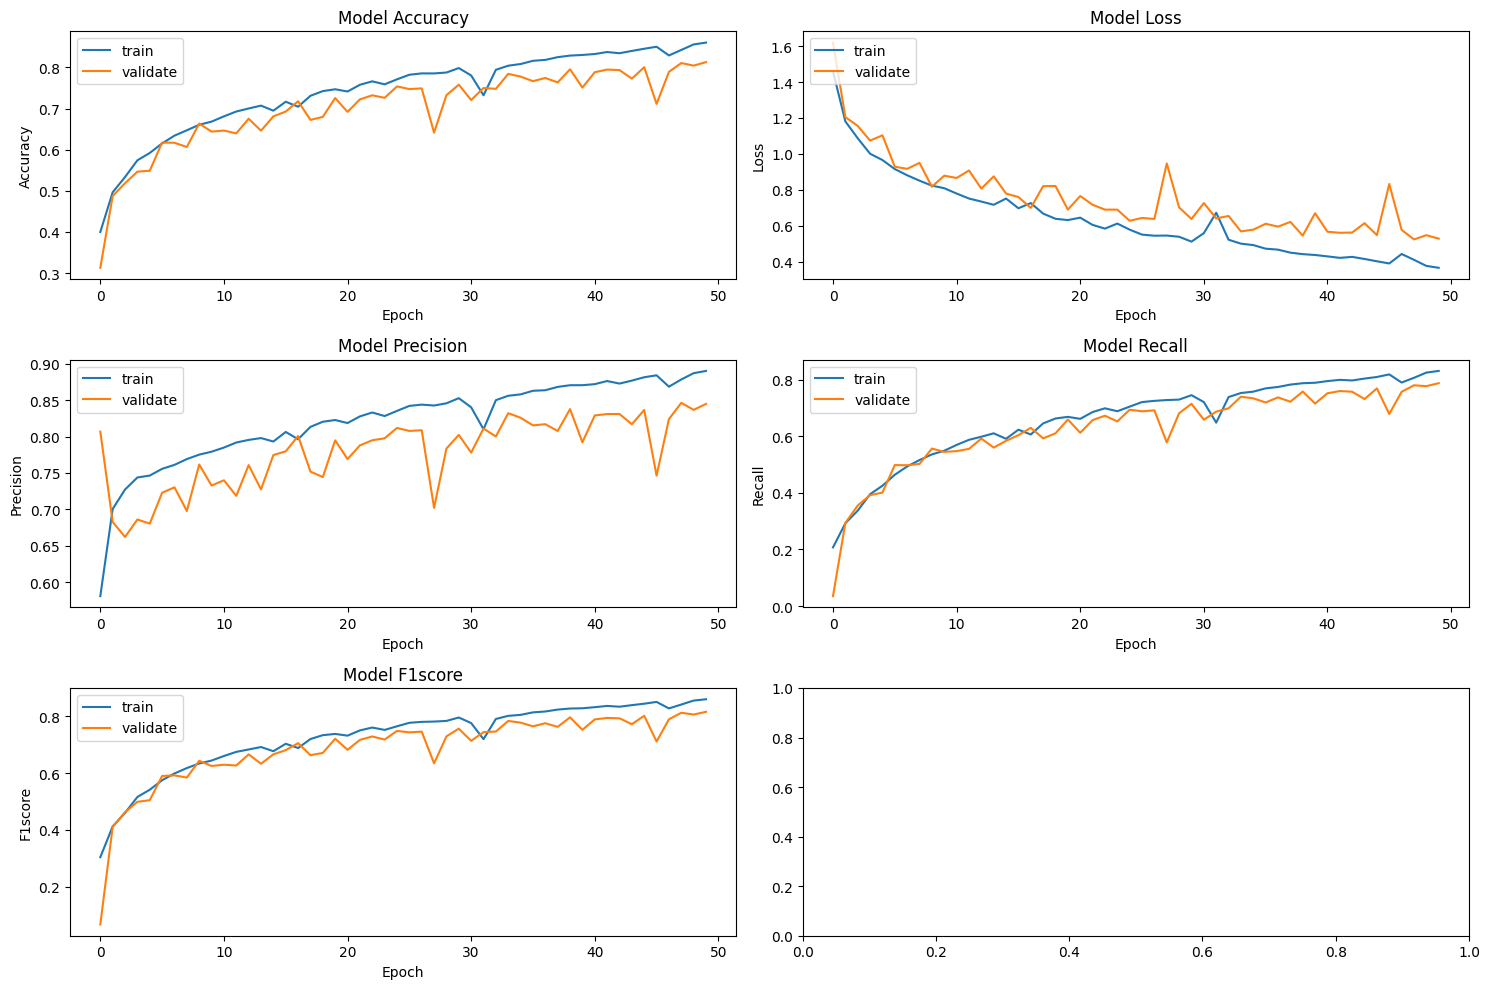

In [14]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train', 'validate'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train', 'validate'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].plot(history.history['val_precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train', 'validate'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].plot(history.history['val_recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train', 'validate'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].plot(history.history['val_f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train', 'validate'], loc='upper left')

    plt.tight_layout()
    plt.show()

# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  2.4111008644104004
Accuracy of test set is:  0.44452720880508423
F1score of test set is:  0.42892640829086304
Precision of test set is:  0.45486366748809814
Recall of test set is:  0.4086780548095703


### Draw confusion matrix

In [16]:
label

array(['left middle', 'left ring', 'left thumb', 'left little',
       'left index'], dtype='<U11')

In [17]:
labels = list(label)
labels

['left middle', 'left ring', 'left thumb', 'left little', 'left index']

4473/4473 [==============================] - 35s 8ms/step


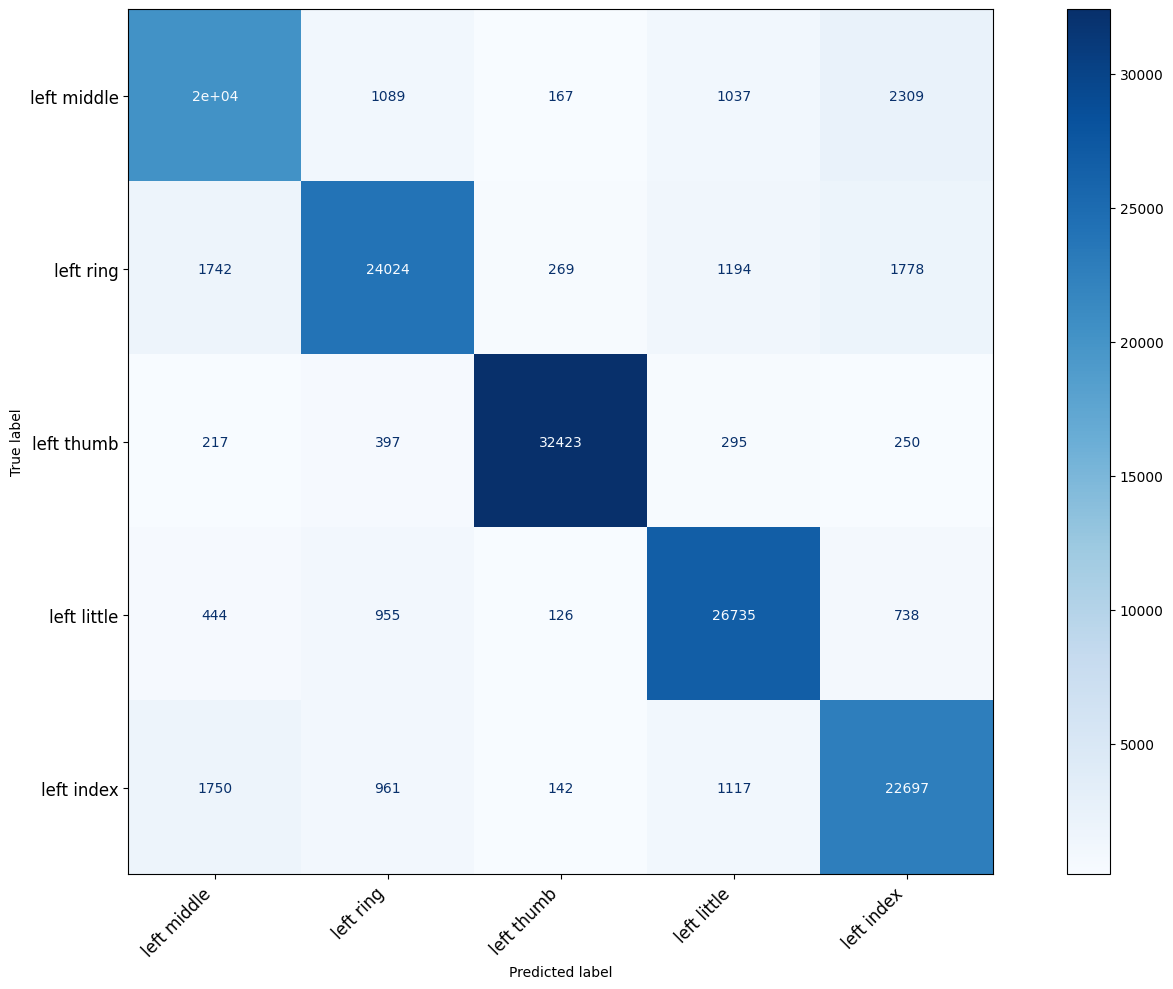

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


1343/1343 [==============================] - 10s 7ms/step


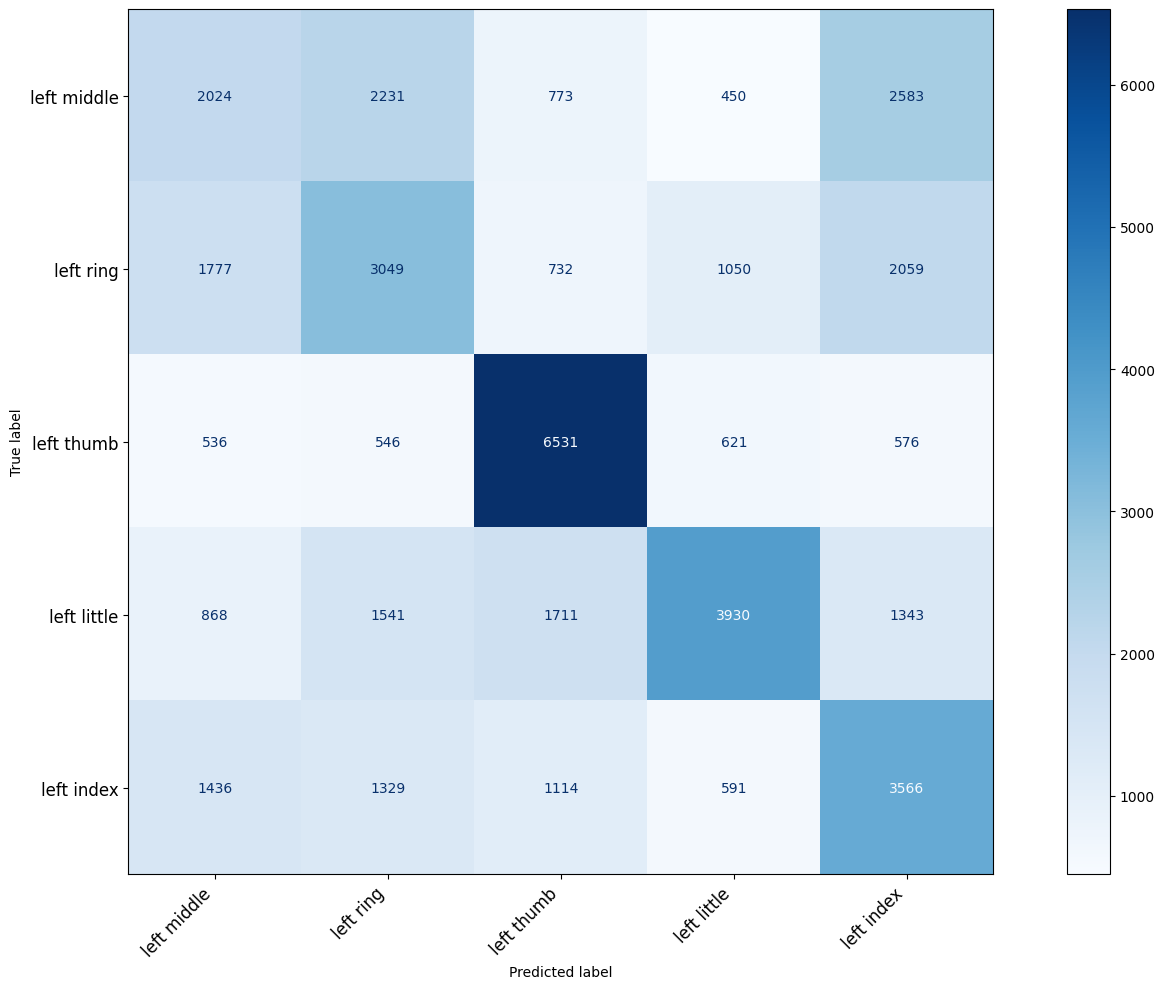

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape